In [2]:
%matplotlib inline

# How to Use `eddy`

I've tried to combine all the functions needed to measure the rotation velocities by the approaches discussed in the previous Notebooks into a simple Python package. I've also included a couple of functions to help build model spectra with specific parameters in order to test the functions. It was with these that I was able to write the appendix of Teague et al. (in prep.). In this Notebook I'll try and demonstrate the useage of these functions.

## Building Ensembles

For this method to work we need to have an ensemble of spectra taken from an annulus of constant radius in the disk. We also need the polar angle of where the spectra come from. Note that we have to be careful here as for an inclined disk the position angle of a point is not the same as its polar angle. The latter will take into account the inclination and can lead to biases in the resulting method.

### Simple Models with `gaussian_ensemble`

We can quickly build some ensembles with the functions in `modelling`. The most simple is the `gaussian_ensemble` which is just $N$ Gaussian lines around the azimuthal angle. We just need to provide it a $v_{\rm rot}$ value and it will do the rest, returning the spectra, the polar angles of the pixels and the velocity axis.

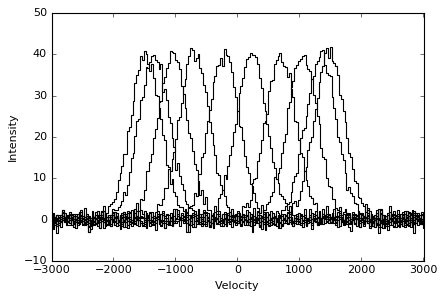

In [3]:
from eddy.modelling import gaussian_ensemble

spectra, theta, velax = gaussian_ensemble(vrot=1500.)

There are a lot of different variables you can choose to change the sort of spectra. I've tried to document them all in the docstrings for the functions which you can access by:

```
>> gaussian_ensemble?
```

Some of the more obvious variables are `N`, the number of spectra, `Tb`, the line peak, `dV`, the Doppler linewidth, `dV_chan`, the channel width and finally `rms`, the rms noise (assumed to be Gaussian and random) which is added to all spectra.

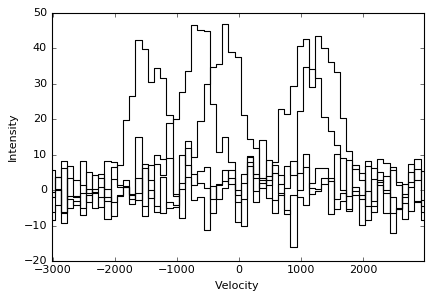

In [4]:
spectra, theta, velax = gaussian_ensemble(vrot=1500., N=5, dV=400., rms=5.0, dV_chan=100.)

We can also consider the case when the lines become optically thick by including a `tau` value.

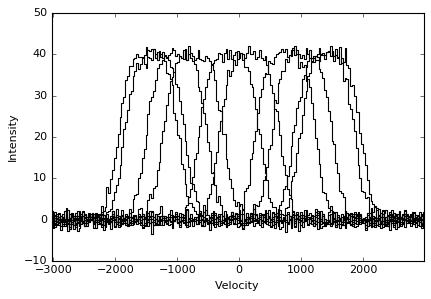

In [5]:
spectra, theta, velax = gaussian_ensemble(vrot=1500., tau=5.0)

### High Resolution Observations with `flared_disk_ensemble`

With the quality of the ALMA data available, we can now spatially resolve the near and far sides of disks when observing a molecular line which arises from an elevated layer, as shown below. This means that in certain regions of the disk (most specifically in the regions between the major and minor axes), a pixel will have two contributions: one from the near side and one from the far side.

---

![12CO in HD163296.](Images/HD163296_Rosenfeld2013.png)

Channel maps of 12CO emission in HD163296 clearly showing the splitting of the near and far side of the disk. Figure taken from [Rosenfeld et al. (2013)](https://ui.adsabs.harvard.edu/#abs/2013ApJ...774...16R).

---

The `flared_disk_ensemble` function tries to model this. The basic idea is that the user will specify where the emission from the front will come from and then it calculates where the secondary component will come from. Unlike `gaussian_ensemble`, $v_{\rm rot}$ is not specified, rather the radius in the disk, the inclination of the disk, `inc`, and the stellar mass, `mstar`. Many of the same variables from `gaussian_ensemble` work here.

Rotation velocity: 1395 m/s.


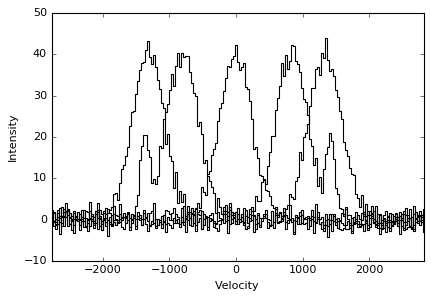

In [6]:
from eddy.modelling import flared_disk_ensemble

spectra, theta, velax, vrot = flared_disk_ensemble(radius=1.0, rms=1.5, N=5)

The two main factors which affect the secondary component are the inclination of the disk and the height of the emission. You can change the height of the emission using the `aspect_ratio` and `flaring_angle` parameters which are related to the height via:

```python
z_disk = aspect_ratio * np.power(r_disk, flaring_angle)
```

With more flaring (or more vertical extent), there is a larger offset between the major and minor components.

Rotation velocity: 1477 m/s.


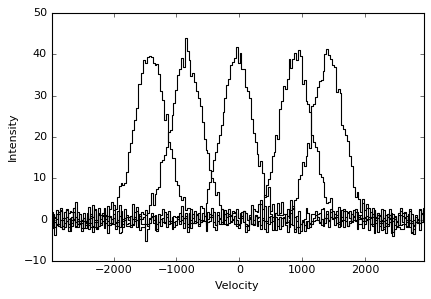

In [7]:
spectra, theta, velax, vrot = flared_disk_ensemble(radius=1.0, rms=1.5, N=5, aspect_ratio=0.1)

Rotation velocity: 1332 m/s.


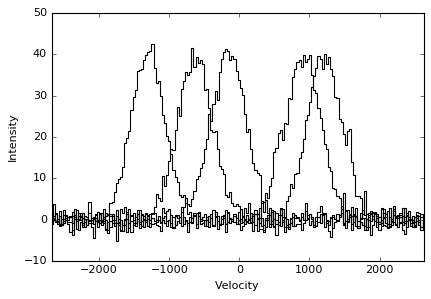

In [8]:
spectra, theta, velax, vrot = flared_disk_ensemble(radius=1.0, rms=1.5, N=5, aspect_ratio=0.4)

The properties of the second component can also be controlled with teh `Tb2` and `dV2` parameters.

## Inferring $v_{\rm rot}$ with `ensemble`

We can use these ensembles directly in the `annulus` class to calculate the rotation profile. There are the two main methods, `get_vrot_dV` which tries to minimize the linewidth of the deprojected spectrum and `get_vrot_GP` which aims to find the smoomthest projected spectrum.

Inferred v_rot from get_vrot_dV(): 1502.30 m/s.
Inferred v_rot from get_vrot_GP(): 1499.83 +\- 1.14 m/s.


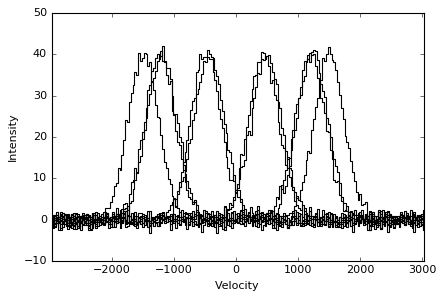

In [9]:
import numpy as np
from eddy.eddy import ensemble

# Build the model spectra and create an ensemble instance.

vrot = 1500.
spectra, theta, velax = gaussian_ensemble(vrot=vrot)
annulus = ensemble(spectra=spectra, theta=theta, velax=velax)

# Find the rotation velocity by minimizing the linewidth:

vrot_dV = annulus.get_vrot_dV()
print("Inferred v_rot from get_vrot_dV(): %.2f m/s." % vrot_dV)

# Find the rotation velocity by finding the smoothest model.

vrot_GP = annulus.get_vrot_GP()
vrot_GP = np.array([vrot_GP[1], vrot_GP[1] - vrot_GP[0], vrot_GP[2] - vrot_GP[1]])
print("Inferred v_rot from get_vrot_GP(): %.2f +\- %.2f m/s." % (vrot_GP[0], np.average(vrot_GP[1:], axis=0)))

Rotation velocity: 1177 m/s.
Inferred v_rot from get_vrot_dV(): 1189.60 m/s.
Inferred v_rot from get_vrot_GP(): 1178.55 +\- 0.53 m/s.


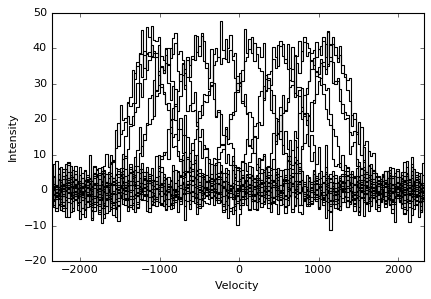

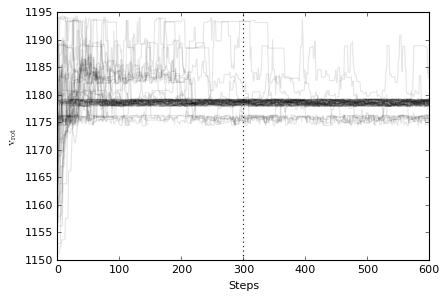

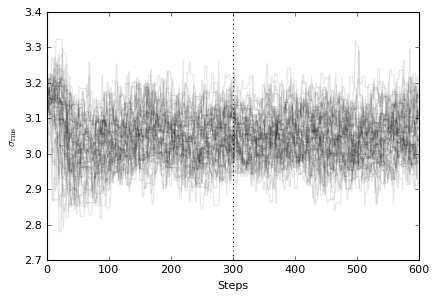

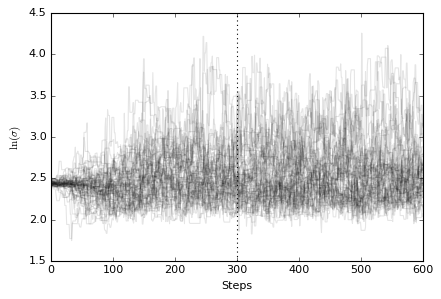

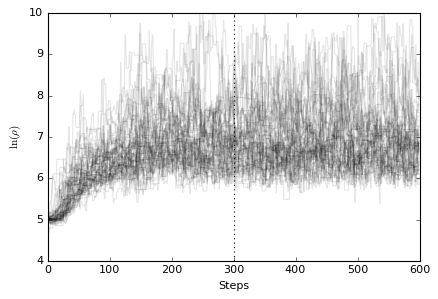

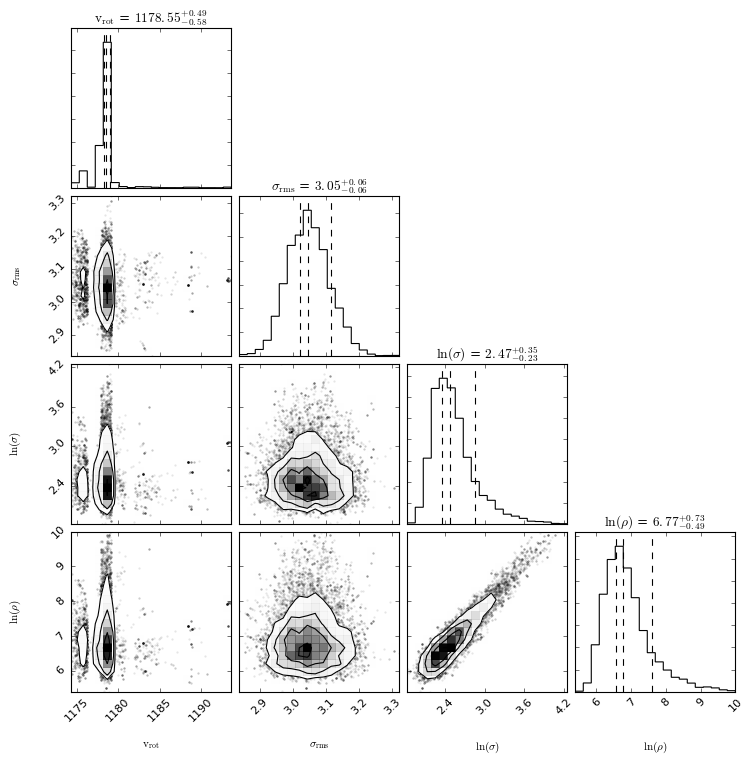

In [10]:
# Try with the flared_disk_ensemble.

spectra, theta, velax, vrot = flared_disk_ensemble(radius=1.5, rms=3.0, N=20, inc=30.,
                                                   aspect_ratio=0.3, flaring_angle=0.12)
annulus = ensemble(spectra=spectra, theta=theta, velax=velax)

# Find the rotation velocity by minimizing the linewidth:

vrot_dV = annulus.get_vrot_dV()
print("Inferred v_rot from get_vrot_dV(): %.2f m/s." % vrot_dV)

# Find the rotation velocity by finding the smoothest model.

vrot_GP = annulus.get_vrot_GP(nwalkers=64, plot_walkers=True, plot_corner=True)
vrot_GP = np.array([vrot_GP[1], vrot_GP[1] - vrot_GP[0], vrot_GP[2] - vrot_GP[1]])
print("Inferred v_rot from get_vrot_GP(): %.2f +\- %.2f m/s." % (vrot_GP[0], np.average(vrot_GP[1:], axis=0)))

In [12]:
from eddy.eddy import ensemble
annulus = ensemble(spectra=spectra, theta=theta, velax=velax)
annulus.get_vrot_GP()

array([ 1177.2696871 ,  1178.47195888,  1179.03108919])